In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Read In

In [2]:
nonqual = pd.read_csv("non_qualifying_uds.csv")
# Duplicate IHAR - cleaned
qual = pd.read_csv("FinalData.csv") 

In [3]:
qual.head()

,ACTUAL_LOS,ADM_IMPAIR_CODE,ADM_IMPAIR_DESC,CMG,CMG_RELATIVE_Weight,COMORBID_DESC_1,COMORBID_DESC_2,COMORBID_ICD_1,COMORBID_ICD_2,ETIOLOGIC_DX,ETIOLOGIC_DX_DESC,EXP_LOS,HOSP_ADMSN_TIME,HOSP_ADSMN_TIME,HOSP_DISCH_TIME,IHAR,IRF,ONSET_DAYS,PATIENT_NUM,y_actual
0,43,1.1000,Left Body Involvement (Right Brain),D0110,2.2511,NaN,NaN,NaN,NaN,I63.9,"Cerebral infarction, unspecifi",24,22-DEC-2015 14:50:00,NaN,03-FEB-2016 11:32:00,301895713,Qualifying Admission impairment,31,13593508.0,HIGH
1,6,16.0000,"Debility (Non-cardiac, Non-pulmonary)",D2004,1.4586,"Systemic lupus erythematosus,",NaN,M32.9,NaN,D61.9,"Aplastic anemia, unspecified",16,18-JAN-2016 16:00:00,NaN,24-JAN-2016 15:15:00,301908121,Qualifying Comorbid condition,49,11423575.0,HIGH
2,32,4.1212,"Quadriplegia, Incomplete C5-8 (Non-Traum)",D0506,2.0123,NaN,NaN,NaN,NaN,S14.154A,"Oth incomplete lesion at C4, i",22,21-JAN-2016 11:29:00,NaN,22-FEB-2016 17:40:00,301909531,Qualifying Admission impairment,346,2260189.0,HIGH
3,5,2.1000,Non-traumatic Brain Dysfunction,D0301,0.8551,NaN,NaN,NaN,NaN,G00.9,"Bacterial meningitis, unspecif",10,29-JAN-2016 14:11:00,NaN,03-FEB-2016 21:03:00,301913503,Qualifying Admission impairment,9,4160743.0,MED
4,29,4.1110,"Paraplegia, Incomplete (Non-Traum)",D0506,2.0123,NaN,NaN,NaN,NaN,G96.0,Cerebrospinal fluid leak,22,01-FEB-2016 17:58:00,NaN,01-MAR-2016 12:25:00,301914385,Qualifying Admission impairment,7,12029449.0,LOW


In [4]:
nonqual['HOSP_ADMSN_TIME'] = pd.to_datetime(nonqual['HOSP_ADMSN_TIME'])
nonqual['HOSP_ADMSN_TIME'] = [d.date() for d in nonqual['HOSP_ADMSN_TIME']]
nonqual['HOSP_DISCH_TIME'] = pd.to_datetime(nonqual['HOSP_DISCH_TIME'])
nonqual['HOSP_DISCH_TIME'] = [d.date() for d in nonqual['HOSP_DISCH_TIME']]
qual['HOSP_ADMSN_TIME'] = pd.to_datetime(qual['HOSP_ADMSN_TIME'])
qual['HOSP_ADMSN_TIME'] = [d.date() for d in qual['HOSP_ADMSN_TIME']]
qual['HOSP_DISCH_TIME'] = pd.to_datetime(qual['HOSP_DISCH_TIME'])
qual['HOSP_DISCH_TIME'] = [d.date() for d in qual['HOSP_DISCH_TIME']]
qual = qual[['PATIENT_NUM','HOSP_ADMSN_TIME','HOSP_DISCH_TIME']]
nonqual = nonqual[['PATIENT_NUM','HOSP_ADMSN_TIME','HOSP_DISCH_TIME']]
nonqual = nonqual.dropna()
nonqual.reset_index(drop=True, inplace=True)
qual = qual.dropna()
qual.reset_index(drop=True, inplace=True)

In [5]:
qual.head(5)

,PATIENT_NUM,HOSP_ADMSN_TIME,HOSP_DISCH_TIME
0,13593508.0,2015-12-22,2016-02-03
1,11423575.0,2016-01-18,2016-01-24
2,2260189.0,2016-01-21,2016-02-22
3,4160743.0,2016-01-29,2016-02-03
4,12029449.0,2016-02-01,2016-03-01


In [6]:
nonqual.head(5)

,PATIENT_NUM,HOSP_ADMSN_TIME,HOSP_DISCH_TIME
0,13917637.0,2016-09-19,2016-09-20
1,14516635.0,2016-09-23,2016-10-04
2,11496613.0,2016-10-11,2016-10-21
3,13312573.0,2016-10-17,2016-10-27
4,13892515.0,2016-10-20,2016-11-02


In [7]:
#data inspection on admission date and discharge date
# import sqlite3
# engine = sqlite3.connect('Uhack')
# nonqual.to_sql('nonqual', con=engine, index=False, if_exists='replace')
# qual.to_sql("qual",con=engine, index=False, if_exists='replace')
# a = pd.read_sql_query('select min(HOSP_ADMSN_TIME) from nonqual', engine).values
# b = pd.read_sql_query('select max(HOSP_DISCH_TIME) from nonqual', engine).values
# c = pd.read_sql_query('select min(HOSP_ADMSN_TIME) from qual', engine).values
# d = pd.read_sql_query('select max(HOSP_ADMSN_TIME) from qual', engine).values

## Restructuring the uds non qualified rehab data into daily record

In [8]:
def func(df_adm, df_disch, df_id):
    restruc = pd.DataFrame(columns=['Dates','id'])
    totalRow = df_adm.count()
    i=0
    while(i<totalRow):
        daterange = pd.date_range(df_adm[i], periods = (df_disch[i]-df_adm[i]).days + 1, freq ='D')
        df_daterange = daterange.to_frame(index=False, name="Dates")
        df_daterange['id'] = df_id[i]
        restruc = restruc.append(df_daterange, ignore_index=True)
        i += 1
    return restruc

In [9]:
nonqualRestr = func(nonqual['HOSP_ADMSN_TIME'], nonqual['HOSP_DISCH_TIME'],nonqual['PATIENT_NUM'])
nonqualCount = nonqualRestr.groupby('Dates').count()[['id']].reset_index().rename(columns={"id": "NbrNonQual"})

In [10]:
nonqualCount.head()

,Dates,NbrNonQual
0,2015-12-29,1
1,2015-12-30,1
2,2015-12-31,1
3,2016-01-01,1
4,2016-01-02,1


## Resturcturing the uds qualified rehab data into daily record

In [11]:
qualRestr = func(qual['HOSP_ADMSN_TIME'], qual['HOSP_DISCH_TIME'],qual['PATIENT_NUM'])
qualCount = qualRestr.groupby('Dates').count()[['id']].reset_index().rename(columns={"id": "NbrQual"})

In [12]:
qualCount.head()

,Dates,NbrQual
0,2015-12-22,1
1,2015-12-23,1
2,2015-12-24,1
3,2015-12-25,2
4,2015-12-26,2


## Merging the nonqualCount and qualCount

In [13]:
import sqlite3
engine = sqlite3.connect('Uhack')
nonqualCount.to_sql('nonqual', con=engine, index=False, if_exists='replace')
qualCount.to_sql("qual",con=engine, index=False, if_exists='replace')

In [14]:
a = pd.read_sql_query('select a.Dates, a.NbrQual, b.NbrNonQual\
                      from qual as a inner join nonqual as b\
                      on a.Dates == b.Dates', engine)
a['PctQual'] = a['NbrQual']/36*100
a['PctNonQual'] = a['NbrNonQual']/36*100
a['totalPct'] = (a['NbrQual']+a['NbrNonQual'])/36*100
a['Dates'] = pd.to_datetime(a['Dates'])
a['Dates'] = [d.date() for d in a['Dates']]
a

,Dates,NbrQual,NbrNonQual,PctQual,PctNonQual,totalPct
0,2015-12-29,2,1,5.555556,2.777778,8.333333
1,2015-12-30,2,1,5.555556,2.777778,8.333333
2,2015-12-31,2,1,5.555556,2.777778,8.333333
3,2016-01-01,3,1,8.333333,2.777778,11.111111
4,2016-01-02,3,1,8.333333,2.777778,11.111111
...,...,...,...,...,...,...
1292,2019-07-15,13,4,36.111111,11.111111,47.222222
1293,2019-07-16,12,4,33.333333,11.111111,44.444444
1294,2019-07-17,10,3,27.777778,8.333333,36.111111
1295,2019-07-18,6,2,16.666667,5.555556,22.222222


## Visualization and Extract Seasonal Pattern

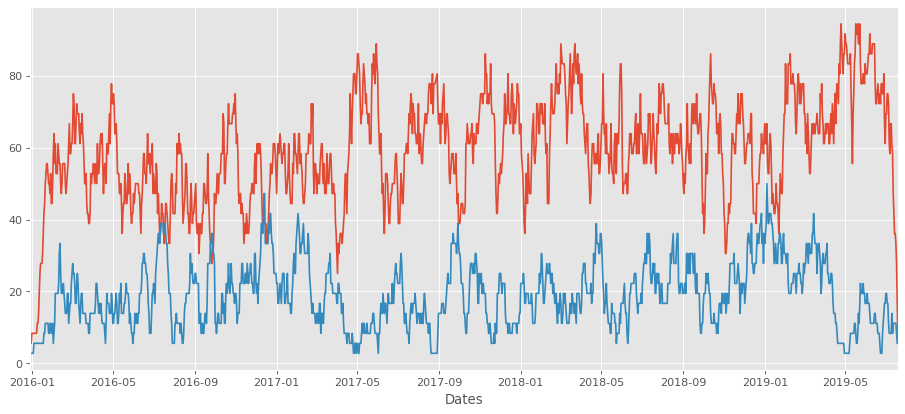

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('ggplot')
b = a.set_index('Dates')
ax = b["PctQual"].plot()
ax2 = b["PctNonQual"].plot()
plt.show()

In [20]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


<Figure size 1800x900 with 0 Axes>

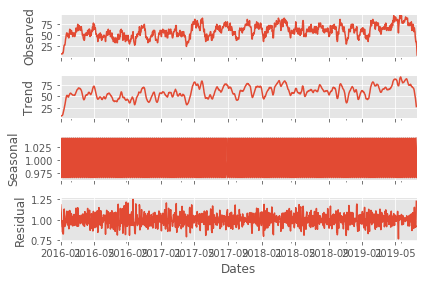

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
figure(num=None, figsize=(20, 10), dpi=90, facecolor='w', edgecolor='k')
plt.style.use('ggplot')
result = seasonal_decompose(b["PctQual"], model='multiplicative', freq=7)
result.plot()
plt.show()

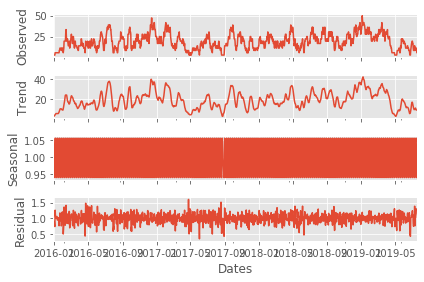

In [18]:
resultNon = seasonal_decompose(b["PctNonQual"], model='multiplicative', freq=7)
resultNon.plot()
plt.show()

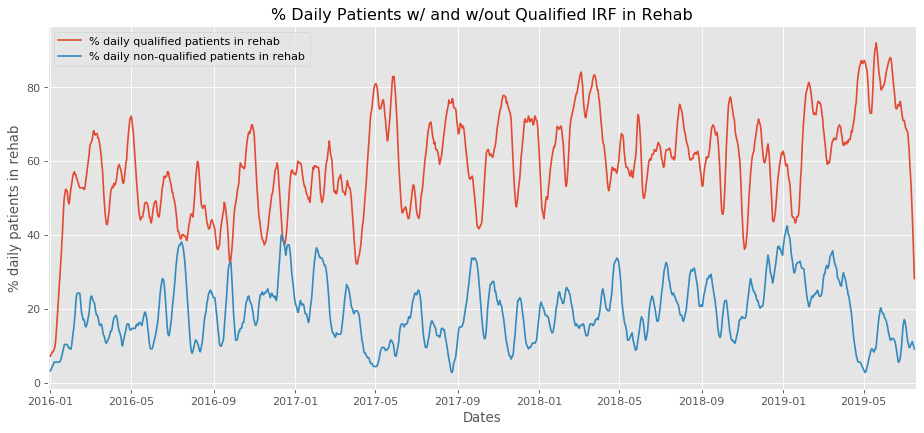

In [25]:
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('ggplot')
b = a.set_index('Dates')
ax = result.trend.plot(label='% daily qualified patients in rehab')
ax2 = resultNon.trend.plot(label='% daily non-qualified patients in rehab')
plt.legend()
plt.title('% Daily Patients w/ and w/out Qualified IRF in Rehab')
plt.ylabel('% daily patients in rehab')
plt.savefig('Percent Patients in Rehab.png', dpi=300)
plt.show()

In [56]:
data = result.trend.to_frame().reset_index()
data.to_sql('delay', con=engine, index=False, if_exists='replace')
y = pd.read_csv("FinalData.csv")
y['HOSP_ADMSN_TIME'] = pd.to_datetime(y['HOSP_ADMSN_TIME'])
y['HOSP_DISCH_TIME'] = pd.to_datetime(qual['HOSP_DISCH_TIME'])
y['Dates'] = [d.date() for d in y['HOSP_ADMSN_TIME']]
y.to_sql('y', con=engine, index=False, if_exists='replace')
final = pd.read_sql_query('select a.*, b.PctQual as RehabDelayScore\
                      from y as a left join delay as b\
                      on a.Dates == b.Dates', engine)

In [57]:
final

,ACTUAL_LOS,ADM_IMPAIR_CODE,ADM_IMPAIR_DESC,CMG,CMG_RELATIVE_Weight,COMORBID_DESC_1,COMORBID_DESC_2,COMORBID_ICD_1,COMORBID_ICD_2,ETIOLOGIC_DX,...,HOSP_ADMSN_TIME,HOSP_ADSMN_TIME,HOSP_DISCH_TIME,IHAR,IRF,ONSET_DAYS,PATIENT_NUM,y_actual,Dates,RehabDelayScore
0,43,1.1000,Left Body Involvement (Right Brain),D0110,2.2511,None,None,None,None,I63.9,...,2015-12-22 14:50:00,None,2016-02-03 00:00:00,301895713,Qualifying Admission impairment,31,13593508.0,HIGH,2015-12-22,NaN
1,6,16.0000,"Debility (Non-cardiac, Non-pulmonary)",D2004,1.4586,"Systemic lupus erythematosus,",None,M32.9,None,D61.9,...,2016-01-18 16:00:00,None,2016-01-24 00:00:00,301908121,Qualifying Comorbid condition,49,11423575.0,HIGH,2016-01-18,36.904762
2,32,4.1212,"Quadriplegia, Incomplete C5-8 (Non-Traum)",D0506,2.0123,None,None,None,None,S14.154A,...,2016-01-21 11:29:00,None,2016-02-22 00:00:00,301909531,Qualifying Admission impairment,346,2260189.0,HIGH,2016-01-21,48.015873
3,5,2.1000,Non-traumatic Brain Dysfunction,D0301,0.8551,None,None,None,None,G00.9,...,2016-01-29 14:11:00,None,2016-02-03 00:00:00,301913503,Qualifying Admission impairment,9,4160743.0,MED,2016-01-29,48.412698
4,29,4.1110,"Paraplegia, Incomplete (Non-Traum)",D0506,2.0123,None,None,None,None,G96.0,...,2016-02-01 17:58:00,None,2016-03-01 00:00:00,301914385,Qualifying Admission impairment,7,12029449.0,LOW,2016-02-01,52.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,15,3.8000,Neuromuscular Disorders,B0604,2.2213,None,None,None,None,G72.81,...,None,05-MAR-2018 14:19:00,None,303088942,Qualifying Admission impairment,139,11408332.0,HIGH,None,NaN
1870,7,4.1300,Other Non-Traumatic Spinal Cord Dysfunction,D0503,1.0895,None,None,None,None,G83.4,...,None,03-SEP-2018 12:01:00,None,309072937,Qualifying Admission impairment,24,2155381.0,HIGH,None,NaN
1871,21,3.8000,Neuromuscular Disorders,C0604,1.7003,None,None,None,None,G72.81,...,None,10-APR-2019 15:36:00,None,309452134,Qualifying Admission impairment,6,22528.0,LOW,None,NaN
1872,14,3.8000,Neuromuscular Disorders,C0604,1.7003,None,None,None,None,G72.81,...,None,19-APR-2019 15:34:00,None,309471760,Qualifying Admission impairment,4,20185645.0,LOW,None,NaN


In [37]:
##Merging the patHos file and UDS 
patHsp = pd.read_excel("pat_hsp.xlsx")
patHsp.head(5)

,SRC,PATIENT_NUM,IHAR,ADT_ARRIVAL_TIME,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,EXP_ADMISSION_TIME,EXP_DISCHARGE_DATE,EXP_LEN_OF_STAY,ADMIT_SOURCE_C,...,BED_TYPE,HOSP_SERV_C,HOSP_SERVICE,DISCH_DISP_C,DISCH_DISP,DISCH_DEST_C,DISCH_DEST,ACCOMMODATION_C,HOSPITAL_AREA_ID,POS_NAME
0,PMR,2542,1217009812,10-FEB-2019 08:26:00,10-FEB-2019 08:28:00,10-FEB-2019 15:00:00,10-FEB-2019 08:26:00,NaN,NaN,25.0,...,NaN,1.0,Emergency,12,To Home Or Self Care,1.0,Home/Self Care,NaN,923,CUH Emergency Medicine
1,PMR,2542,1217009812,13-FEB-2019 13:49:00,13-FEB-2019 13:51:00,20-FEB-2019 15:20:00,NaN,20-FEB-2019 00:00:00,7.0,25.0,...,MED SURG,6.0,Internal Medicine,22,To Rehab Unit Zale Lipshy,NaN,NaN,10000.0,5053,Clements University Hospital
2,PMR,4111,309245824,NaN,07-DEC-2018 21:30:00,11-DEC-2018 19:15:00,07-DEC-2018 20:37:00,11-DEC-2018 00:00:00,4.0,36.0,...,MED SURG,6.0,Internal Medicine,20,To Rehab Facility Other,10.0,Other,100013.0,5050,ZALE LIPSHY UNIVERSITY HOSPITAL
3,PMR,4798,1217664661,NaN,26-MAR-2019 08:30:00,02-APR-2019 12:05:00,26-MAR-2019 09:57:00,02-APR-2019 00:00:00,7.0,25.0,...,NaN,25.0,Surgery,22,To Rehab Unit Zale Lipshy,NaN,NaN,10000.0,5053,Clements University Hospital
4,PMR,5305,302720212,NaN,13-JUN-2017 00:06:00,16-JUN-2017 15:15:00,12-JUN-2017 23:01:00,16-JUN-2017 00:00:00,3.0,36.0,...,STROKE BED,8.0,Neurology,22,To Rehab Unit Zale Lipshy,NaN,NaN,100009.0,5050,ZALE LIPSHY UNIVERSITY HOSPITAL


In [38]:
patHsp['HOSP_DISCH_TIME'] = pd.to_datetime(patHsp['HOSP_DISCH_TIME'])
patHsp['EXP_DISCHARGE_DATE'] = pd.to_datetime(patHsp['EXP_DISCHARGE_DATE'])
patHsp['HOSP_ADMSN_TIME'] = pd.to_datetime(patHsp['HOSP_ADMSN_TIME'])
patHsp['HOSP_DISCH_DATE'] = [d.date() for d in patHsp['HOSP_DISCH_TIME']]
patHsp['EXP_DISCHARGE_DATE'] = [d.date() for d in patHsp['EXP_DISCHARGE_DATE']]
patHsp['HOSP_ADMSN_TIME'] = [d.date() for d in patHsp['HOSP_ADMSN_TIME']]
patHsp['LOS_HOSP'] = patHsp['HOSP_DISCH_DATE'] - patHsp['HOSP_ADMSN_TIME']
patHsp['LOS_HOSP'] = [d.days for d in patHsp['LOS_HOSP']]
patHsp['DISCH_DELEY'] = patHsp['HOSP_DISCH_DATE'] - patHsp['EXP_DISCHARGE_DATE']
patHsp['DISCH_DELEY'] = [d.days for d in patHsp['DISCH_DELEY']]
patHsp.head(5)

,SRC,PATIENT_NUM,IHAR,ADT_ARRIVAL_TIME,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,EXP_ADMISSION_TIME,EXP_DISCHARGE_DATE,EXP_LEN_OF_STAY,ADMIT_SOURCE_C,...,DISCH_DISP_C,DISCH_DISP,DISCH_DEST_C,DISCH_DEST,ACCOMMODATION_C,HOSPITAL_AREA_ID,POS_NAME,HOSP_DISCH_DATE,LOS_HOSP,DISCH_DELEY
0,PMR,2542,1217009812,10-FEB-2019 08:26:00,2019-02-10,2019-02-10 15:00:00,10-FEB-2019 08:26:00,NaT,NaN,25.0,...,12,To Home Or Self Care,1.0,Home/Self Care,NaN,923,CUH Emergency Medicine,2019-02-10,0,NaN
1,PMR,2542,1217009812,13-FEB-2019 13:49:00,2019-02-13,2019-02-20 15:20:00,NaN,2019-02-20,7.0,25.0,...,22,To Rehab Unit Zale Lipshy,NaN,NaN,10000.0,5053,Clements University Hospital,2019-02-20,7,0.0
2,PMR,4111,309245824,NaN,2018-12-07,2018-12-11 19:15:00,07-DEC-2018 20:37:00,2018-12-11,4.0,36.0,...,20,To Rehab Facility Other,10.0,Other,100013.0,5050,ZALE LIPSHY UNIVERSITY HOSPITAL,2018-12-11,4,0.0
3,PMR,4798,1217664661,NaN,2019-03-26,2019-04-02 12:05:00,26-MAR-2019 09:57:00,2019-04-02,7.0,25.0,...,22,To Rehab Unit Zale Lipshy,NaN,NaN,10000.0,5053,Clements University Hospital,2019-04-02,7,0.0
4,PMR,5305,302720212,NaN,2017-06-13,2017-06-16 15:15:00,12-JUN-2017 23:01:00,2017-06-16,3.0,36.0,...,22,To Rehab Unit Zale Lipshy,NaN,NaN,100009.0,5050,ZALE LIPSHY UNIVERSITY HOSPITAL,2017-06-16,3,0.0


In [63]:
patHsp.shape

(2040, 21)

In [64]:
len(patHsp['PATIENT_NUM'].unique())

1606

In [65]:
len(final['PATIENT_NUM'].unique())

1642

In [66]:
final.merge(patHsp, on=['PATIENT_NUM'], how='left')

,ACTUAL_LOS,ADM_IMPAIR_CODE,ADM_IMPAIR_DESC,CMG,CMG_RELATIVE_Weight,COMORBID_DESC_1,COMORBID_DESC_2,COMORBID_ICD_1,COMORBID_ICD_2,ETIOLOGIC_DX,...,HOSP_SERV_C,HOSP_SERVICE,DISCH_DISP_C,DISCH_DISP,ACCOMMODATION_C,HOSPITAL_AREA_ID,POS_NAME,HOSP_DISCH_DATE,LOS_HOSP,DISCH_DELEY
0,43,1.1000,Left Body Involvement (Right Brain),D0110,2.2511,None,None,None,None,I63.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,16.0000,"Debility (Non-cardiac, Non-pulmonary)",D2004,1.4586,"Systemic lupus erythematosus,",None,M32.9,None,D61.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32,4.1212,"Quadriplegia, Incomplete C5-8 (Non-Traum)",D0506,2.0123,None,None,None,None,S14.154A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,2.1000,Non-traumatic Brain Dysfunction,D0301,0.8551,None,None,None,None,G00.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29,4.1110,"Paraplegia, Incomplete (Non-Traum)",D0506,2.0123,None,None,None,None,G96.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,21,3.8000,Neuromuscular Disorders,C0604,1.7003,None,None,None,None,G72.81,...,55.0,Neurocritical Care,22.0,To Rehab Unit Zale Lipshy,100011.0,5050.0,ZALE LIPSHY UNIVERSITY HOSPITAL,2019-04-12,1.0,0.0
2312,14,3.8000,Neuromuscular Disorders,C0604,1.7003,None,None,None,None,G72.81,...,NaN,NaN,12.0,To Home Or Self Care,NaN,773.0,CUH PATHOLOGY,2019-04-11,0.0,NaN
2313,14,3.8000,Neuromuscular Disorders,C0604,1.7003,None,None,None,None,G72.81,...,26.0,"Surgery, Surgical Transplantation",22.0,To Rehab Unit Zale Lipshy,10000.0,5053.0,Clements University Hospital,2019-04-19,12.0,0.0
2314,10,3.8000,Neuromuscular Disorders,A0604,1.4334,None,None,None,None,G72.81,...,22.0,Pulmonary,22.0,To Rehab Unit Zale Lipshy,100022.0,5053.0,Clements University Hospital,2019-05-28,31.0,0.0


In [39]:
patHsp = patHsp[['SRC', 'PATIENT_NUM', 'HOSP_ADMSN_TIME', 'HOSP_DISCH_TIME', 'EXP_DISCHARGE_DATE',
       'EXP_LEN_OF_STAY', 'ADMIT_SOURCE_C', 'ADMIT_SOURCE', 'ADM_EVENT_ID', 'ADT_PAT_CLASS_C', 
       'ADT_PAT_CLASS', 'HOSP_SERV_C', 'HOSP_SERVICE', 'DISCH_DISP_C', 'DISCH_DISP', 
       'ACCOMMODATION_C', 'HOSPITAL_AREA_ID', 'POS_NAME', 'HOSP_DISCH_DATE', 'LOS_HOSP','DISCH_DELEY']]

In [40]:
patHsp.to_sql('patHsp', con=engine, index=False, if_exists='replace')
final.to_sql('final', con=engine, index=False, if_exists='replace')


In [41]:
final.count()

ACTUAL_LOS             1874
ADM_IMPAIR_CODE        1874
ADM_IMPAIR_DESC        1874
CMG                    1874
CMG_RELATIVE_Weight    1874
COMORBID_DESC_1         161
COMORBID_DESC_2          22
COMORBID_ICD_1          161
COMORBID_ICD_2           22
ETIOLOGIC_DX           1874
ETIOLOGIC_DX_DESC      1857
EXP_LOS                1874
HOSP_ADMSN_TIME        1837
HOSP_ADSMN_TIME          14
HOSP_DISCH_TIME        1851
IHAR                   1874
IRF                    1874
ONSET_DAYS             1874
PATIENT_NUM            1851
y_actual               1874
Dates                  1837
RehabDelayScore        1832
dtype: int64

In [54]:
patHsp.dtypes

SRC                           object
PATIENT_NUM                    int64
HOSP_ADMSN_TIME               object
HOSP_DISCH_TIME       datetime64[ns]
EXP_DISCHARGE_DATE            object
EXP_LEN_OF_STAY              float64
ADMIT_SOURCE_C               float64
ADMIT_SOURCE                  object
ADM_EVENT_ID                 float64
ADT_PAT_CLASS_C                int64
ADT_PAT_CLASS                 object
HOSP_SERV_C                  float64
HOSP_SERVICE                  object
DISCH_DISP_C                   int64
DISCH_DISP                    object
ACCOMMODATION_C              float64
HOSPITAL_AREA_ID               int64
POS_NAME                      object
HOSP_DISCH_DATE               object
LOS_HOSP                       int64
DISCH_DELEY                  float64
dtype: object

In [59]:
final['HOSP_ADMSN_TIME'] = pd.to_datetime(final['HOSP_ADMSN_TIME'])

In [60]:
final.dtypes

ACTUAL_LOS                      int64
ADM_IMPAIR_CODE               float64
ADM_IMPAIR_DESC                object
CMG                            object
CMG_RELATIVE_Weight           float64
COMORBID_DESC_1                object
COMORBID_DESC_2                object
COMORBID_ICD_1                 object
COMORBID_ICD_2                 object
ETIOLOGIC_DX                   object
ETIOLOGIC_DX_DESC              object
EXP_LOS                         int64
HOSP_ADMSN_TIME        datetime64[ns]
HOSP_ADSMN_TIME                object
HOSP_DISCH_TIME                object
IHAR                            int64
IRF                            object
ONSET_DAYS                      int64
PATIENT_NUM                   float64
y_actual                       object
Dates                          object
RehabDelayScore               float64
dtype: object

In [68]:
merged= pd.read_sql_query('select a.*, b.* from final as a left join patHsp as b\
                            on a.PATIENT_NUM == b.PATIENT_NUM and (datetime(a.HOSP_ADMSN_TIME)-datetime(b.HOSP_DISCH_TIME))<1\
                             and  (datetime(a.HOSP_ADMSN_TIME)-datetime(b.HOSP_DISCH_TIME))>=0', engine)
merged.count()

ACTUAL_LOS             2186
ADM_IMPAIR_CODE        2186
ADM_IMPAIR_DESC        2186
CMG                    2186
CMG_RELATIVE_Weight    2186
COMORBID_DESC_1         212
COMORBID_DESC_2          28
COMORBID_ICD_1          212
COMORBID_ICD_2           28
ETIOLOGIC_DX           2186
ETIOLOGIC_DX_DESC      2167
EXP_LOS                2186
HOSP_ADMSN_TIME        2149
HOSP_ADSMN_TIME          14
HOSP_DISCH_TIME        2163
IHAR                   2186
IRF                    2186
ONSET_DAYS             2186
PATIENT_NUM            2163
y_actual               2186
Dates                  2149
RehabDelayScore        2144
SRC                    1323
PATIENT_NUM            1323
HOSP_ADMSN_TIME        1323
HOSP_DISCH_TIME        1323
EXP_DISCHARGE_DATE     1213
EXP_LEN_OF_STAY        1008
ADMIT_SOURCE_C         1323
ADMIT_SOURCE           1323
ADM_EVENT_ID           1224
ADT_PAT_CLASS_C        1323
ADT_PAT_CLASS          1323
HOSP_SERV_C            1224
HOSP_SERVICE           1224
DISCH_DISP_C        

In [ ]:
final

In [69]:
merged.to_csv('Merged_UDS_Qualified_with_Pat_HOSP.csv')

In [70]:
final.to_csv('FinalUDS.csv')

In [71]:
patHsp.to_csv('patHsp.csv')